In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

from dslab_virgo_tsi.visualizer import Visualizer
from dslab_virgo_tsi.base import Result, BaseSignals, OutResult, FinalResult
from dslab_virgo_tsi.constants import Constants as Const
from dslab_virgo_tsi.data_utils import load_data

In [2]:
visualizer = Visualizer()
visualizer.set_figsize()

In [3]:
with open("./results/SMOOTH_MONOTONIC_modeling_result.pkl", "rb") as handle:
    result: Result = pickle.load(handle)
        
base_sig: BaseSignals = result.base_signals
out_res: OutResult = result.out
final_res: FinalResult = result.final

other_res = load_data(Const.DATA_DIR, Const.VIRGO_TSI_FILE, "virgo_tsi")
other_tsi = other_res[Const.PMO6V_OLD].values
other_t = other_res[Const.T].values
other_triplet = (other_t, other_tsi, f"{Const.PMO6V_OLD}_corrected")
other_fourplet = (other_t, other_tsi, f"{Const.PMO6V_OLD}_corrected", False)

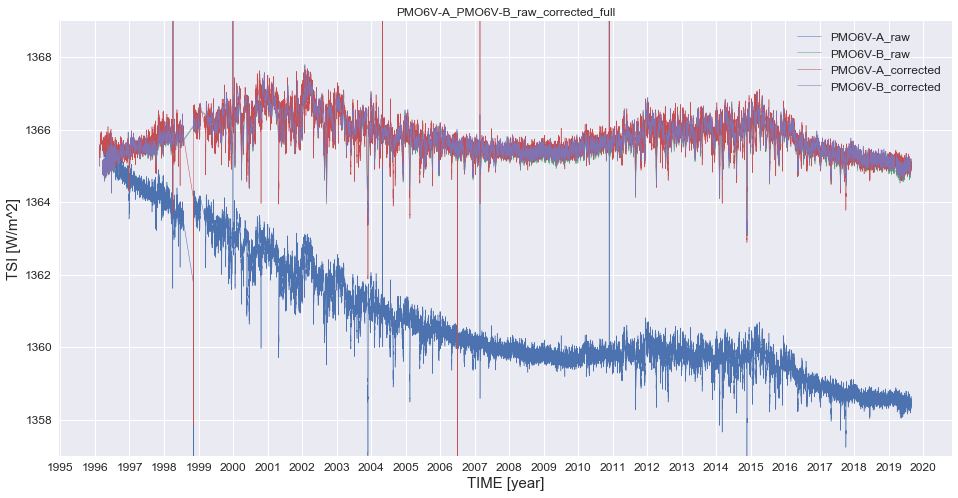

In [4]:
visualizer.plot_signals(
[
    (base_sig.t_a_nn, base_sig.a_nn, f"{Const.A}_raw", False),
    (base_sig.t_b_nn, base_sig.b_nn, f"{Const.B}_raw", False),
    (base_sig.t_a_nn, final_res.a_nn_corrected, f"{Const.A}_corrected", False),
    (base_sig.t_b_nn, final_res.b_nn_corrected, f"{Const.B}_corrected", False),
],
None, f"{Const.A}_{Const.B}_raw_corrected_full", x_ticker=1, y_lim=[1357, 1369],
legend="upper right", x_label=Const.YEAR_UNIT, y_label=Const.TSI_UNIT, max_points=1e5)

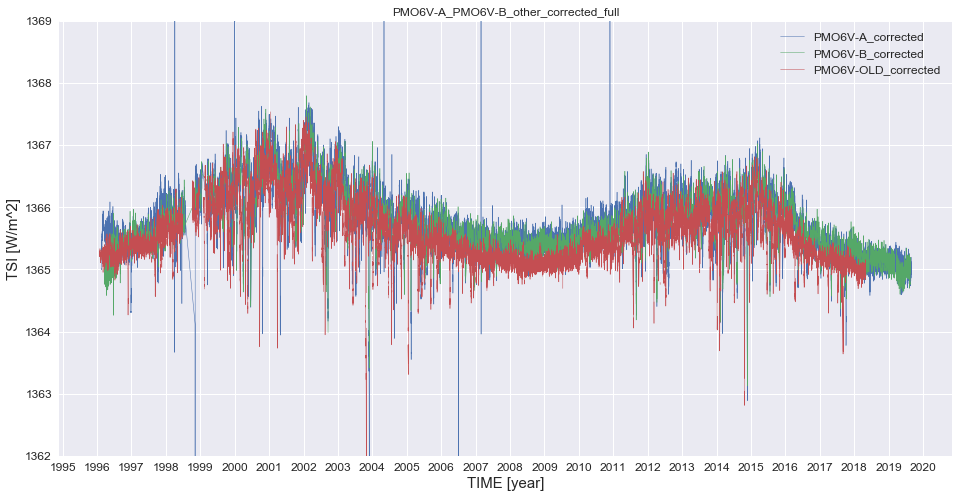

In [5]:
visualizer.plot_signals(
[
    (base_sig.t_a_nn, final_res.a_nn_corrected, f"{Const.A}_corrected", False),
    (base_sig.t_b_nn, final_res.b_nn_corrected, f"{Const.B}_corrected", False),
    other_fourplet
],
None, f"{Const.A}_{Const.B}_other_corrected_full", x_ticker=1, y_lim=[1362, 1369],
legend="upper right", x_label=Const.YEAR_UNIT, y_label=Const.TSI_UNIT)

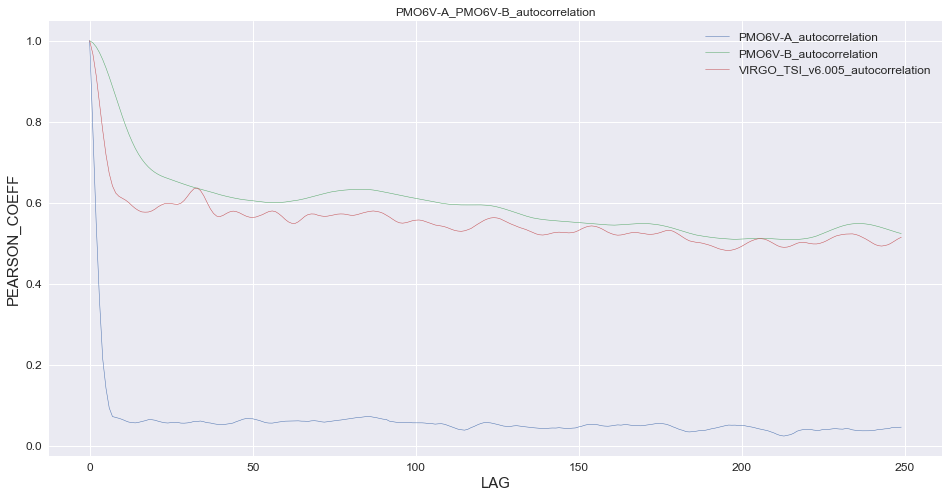

In [78]:
from scipy import interpolate
from scipy.optimize import curve_fit

t_min = np.max([other_t[0], base_sig.t_a_nn[0], base_sig.t_b_nn[0]])
t_max = np.min([other_t[-1], base_sig.t_a_nn[-1], base_sig.t_b_nn[-1]])

n_points = 10000
t = np.linspace(t_min, t_max, n_points)
f_a = interpolate.interp1d(base_sig.t_a_nn, final_res.a_nn_corrected)
f_b = interpolate.interp1d(base_sig.t_b_nn, final_res.b_nn_corrected)
f_o = interpolate.interp1d(other_t, other_tsi)

a, b, o = pd.Series(f_a(t)), pd.Series(f_b(t)), pd.Series(f_o(t))
o = o.interpolate("nearest")

lags = np.arange(0, n_points // 40, 1)
n = lags.shape[0]
acorr_a, acorr_b, acorr_o = np.zeros(n), np.zeros(n), np.zeros(n)

for idx, lag in enumerate(lags):
    acorr_a[idx] = a.autocorr(lag=lag)
    acorr_b[idx] = b.autocorr(lag=lag)
    acorr_o[idx] = o.autocorr(lag=lag)

visualizer.plot_signals(
[
    (lags, acorr_a, f"{Const.A}_autocorrelation", False),
    (lags, acorr_b, f"{Const.B}_autocorrelation", False),
    (lags, acorr_o, f"VIRGO_TSI_v6.005_autocorrelation", False),
],
None, f"{Const.A}_{Const.B}_autocorrelation",
legend="upper right", x_label="LAG", y_label="PEARSON_COEFF")

b [1.77530544e-02 4.23531998e-01 2.08767566e+01 5.58714948e-01]
o [-0.026744    0.48738713  5.79243186  0.53935687]


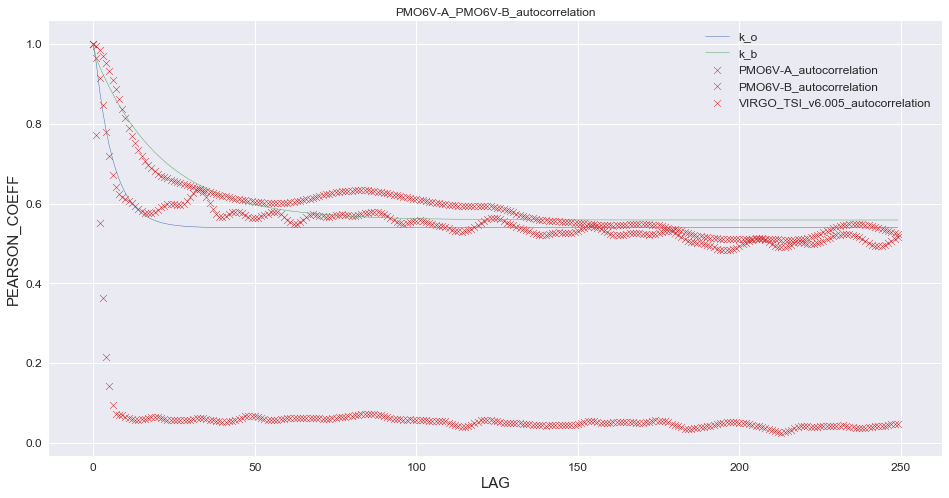

In [81]:
def matern12(d, a0, a1):
    return a0 * np.exp(-d/a1)

def white(d, a0):
    return (d == 0) * a0

def constant(d, a0):
    return a0

def kernel(d, a0, a1, a2, a3):
    return white(d, a0) + matern12(d, a1, a2) + constant(d, a3)

popt_b, _ = curve_fit(kernel, lags, acorr_b, p0=[1.0, 1.0, 1.0, 1.0], maxfev=10000)
popt_o, _ = curve_fit(kernel, lags, acorr_o, p0=[1.0, 1.0, 1.0, 1.0], maxfev=10000)

print("b", popt_b)
print("o", popt_o)

k_b, k_o = kernel(lags, *popt_b), kernel(lags, *popt_o)

visualizer.plot_signals(
[
    (lags, acorr_a, f"{Const.A}_autocorrelation", True),
    (lags, acorr_b, f"{Const.B}_autocorrelation", True),
    (lags, acorr_o, f"VIRGO_TSI_v6.005_autocorrelation", True),
    (lags, k_o, "k_o", False), (lags, k_b, "k_b", False)
],
None, f"{Const.A}_{Const.B}_autocorrelation",
legend="upper right", x_label="LAG", y_label="PEARSON_COEFF")

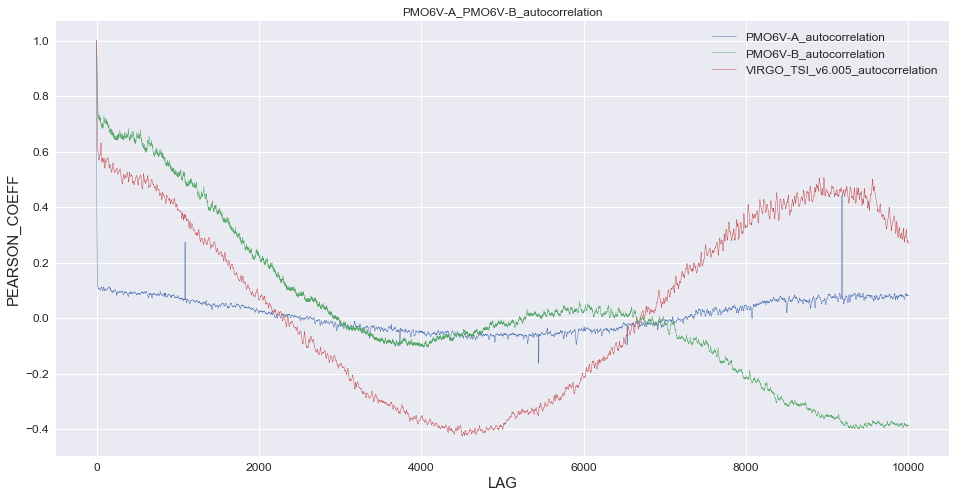

In [40]:
a, b, o = pd.Series(final_res.a_nn_corrected), pd.Series(final_res.b_nn_corrected), pd.Series(other_tsi)
a, b, o = a[::600], b[::2], o[::12]

n = 10000
acorr_a, acorr_b, acorr_o = np.zeros(n), np.zeros(n), np.zeros(n)

lags = np.arange(0, n, 1)
for idx, lag in enumerate(lags):
    acorr_a[idx] = a.autocorr(lag=lag)
    acorr_b[idx] = b.autocorr(lag=lag)
    acorr_o[idx] = o.autocorr(lag=lag)
    
visualizer.plot_signals(
[
    (lags, acorr_a, f"{Const.A}_autocorrelation", False),
    (lags, acorr_b, f"{Const.B}_autocorrelation", False),
    (lags, acorr_o, f"VIRGO_TSI_v6.005_autocorrelation", False),
],
None, f"{Const.A}_{Const.B}_autocorrelation",
legend="upper right", x_label="LAG", y_label="PEARSON_COEFF")